<a href="https://colab.research.google.com/github/aryanVanaik/COTE-risk-and-point-manager/blob/main/Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###The Imports

In [24]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import tqdm.auto as tqdm
## Importing non standard libries
try:
  import torchmetrics

except:
  !pip install torchmetrics
  import torchmetrics

from torchmetrics.classification import Accuracy

In [25]:
# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

## Obtaining Data provided by courtrsy of mkdbourke github link: https://github.com/mrdbourke/pytorch-deep-learning

In [26]:
import requests
import zipfile
from pathlib import Path

# path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesnt exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory exists skipping download")

else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True,exist_ok=True)

with open(data_path/"pizza_steak_sushi.zip","wb") as f:
 
  request = requests.get(" https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza steak, sushi data")
  f.write(request.content)

with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping data")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi directory exists skipping download
Unzipping data


In [27]:
# Setup train and testing paths
train_dir = image_path/ "train"
test_dir = image_path/ "test"

### Creating the datasets

In [28]:
from torchvision import transforms,datasets
train_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor() 
])

test_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor() 
])

In [29]:


train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_transform, # a tranform for the data
                                  target_transform=None) # a transfrom for the label/target 

test_data = datasets.ImageFolder(root=test_dir,
                                  transform=test_transform, # a tranform for the data
                                  target_transform=None)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
            ), Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
            ))

In [30]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [31]:
# Batchifying the data 
from torch.utils.data import DataLoader
BATCH_SIZE=32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=True)

### The Model will be a smaller representation of the VGG16 network called TinyVGG Implemeted here: https://poloclub.github.io/cnn-explainer/


In [64]:
class TinyVGG(nn.Module):
  def __init__(self,input_shape:int, hidden_units:int, output_shape:int) -> None:
    super().__init__()
    self.conv_layer1 = nn.Sequential(
        nn.Conv2d(in_channels= input_shape,
                  out_channels = hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels =hidden_units,
                  kernel_size=3,
                  stride=1,padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.conv_layer2 = nn.Sequential(
        nn.Conv2d(in_channels= hidden_units,
                  out_channels= hidden_units,
                  kernel_size=3,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(hidden_units,hidden_units, kernel_size=3, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units *13*13,
                  out_features = output_shape,
                )
    )

  def forward(self,x):
      # x = self.conv_layer1(x)
      # print(x.shape)
      # x = self.conv_layer2(x)
      # print(x.shape)
      # x = self.classifier(x)
      # print(x.shape)
      # return x

    return self.classifier(self.conv_layer2(self.conv_layer1(x)))

In [65]:
# The Model
model_0 = TinyVGG(3,10,len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_layer1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

## Functions for training and testing loop


In [62]:
def train_batch(model:torch.nn.Module,
                dataloader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                optimizer:torch.optim.Optimizer,
                device =device):
  model.train()

  train_loss,train_acc=0,0


  for batch, (X,y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)

    loss=loss_fn(y_pred,y)
    train_loss+=loss.item()

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)


  train_loss = train_loss/len(dataloader)
  train_acc = train_acc/len(dataloader)

  return train_loss,train_acc


  

In [61]:
def test_batch(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn=torch.nn.Module,
               device=device):
  model.eval()
  test_loss,test_acc =0,0
  
  with torch.inference_mode():
    for batch,(X,y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)
      test_logits = model(X)

      loss = loss_fn(test_logits,y)
      test_loss += loss.item()

      test_pred_label = torch.argmax(torch.softmax(test_logits,dim=1),dim=1)
      test_acc += ((test_pred_label==y).sum().item()/len(test_pred_label))
  test_loss = test_loss/len(dataloader)
  test_acc = test_acc/len(dataloader)
  return test_loss,test_acc



In [53]:
def full_train(model:torch.nn.Module,
               train_dataloader: torch.utils.data.DataLoader,
               test_dataloader:torch.utils.data.DataLoader,
               optimizer:torch.optim.Optimizer,
               loss_fn:torch.nn.Module,
               epochs:int,
               device = device):
  results = {
      "train_loss":[],
      "train_acc":[],
      "test_loss":[],
      "test_acc":[]
  }
  for epoch in range(epochs):
    train_loss,train_acc = train_batch(model,train_dataloader,loss_fn,optimizer,device)
    test_loss,test_acc = test_batch(model,train_dataloader,loss_fn,device)

    print(f"Epoch: {epoch} | Train_loss: {train_loss:.4f} | Train_acc: {train_acc:.4f} | Test_loss: {test_loss:.4f} | Test_acc {test_acc:.4f}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results
  

In [69]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =model_0.parameters(), lr=0.0001)

In [70]:
model_0_results = full_train(model = model_0,
                             train_dataloader=train_dataloader,
                             test_dataloader =test_dataloader,
                             loss_fn=loss_fn,
                             optimizer =optimizer,
                             epochs=10)

Epoch: 0 | Train_loss: 1.0995 | Train_acc: 0.2812 | Test_loss: 1.0987 | Test_acc 0.2812
Epoch: 1 | Train_loss: 1.0970 | Train_acc: 0.4180 | Test_loss: 1.0965 | Test_acc 0.4258
Epoch: 2 | Train_loss: 1.0996 | Train_acc: 0.3047 | Test_loss: 1.1015 | Test_acc 0.3047
Epoch: 3 | Train_loss: 1.0943 | Train_acc: 0.4258 | Test_loss: 1.0990 | Test_acc 0.3047
Epoch: 4 | Train_loss: 1.1029 | Train_acc: 0.3047 | Test_loss: 1.1029 | Test_acc 0.3047
Epoch: 5 | Train_loss: 1.1004 | Train_acc: 0.3047 | Test_loss: 1.1018 | Test_acc 0.3047
Epoch: 6 | Train_loss: 1.0997 | Train_acc: 0.3047 | Test_loss: 1.0938 | Test_acc 0.4258
Epoch: 7 | Train_loss: 1.0948 | Train_acc: 0.4258 | Test_loss: 1.0945 | Test_acc 0.4258
Epoch: 8 | Train_loss: 1.0987 | Train_acc: 0.3047 | Test_loss: 1.1032 | Test_acc 0.3047
Epoch: 9 | Train_loss: 1.0946 | Train_acc: 0.4258 | Test_loss: 1.1039 | Test_acc 0.3047


In [67]:
model_0_results.keys()
def plot_loss_curves(results):
  """PLots training curves of results dictionary"""

  loss = results["train_loss"]
  test_loss = results["test_loss"]

  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]
  
  epochs = range(len(results["train_loss"]))

  plt.figure(figsize=(15,7))
  
  plt.subplot(1,2,1)
  plt.plot(epochs,loss,label="train_loss")
  plt.plot(epochs,test_loss,label="test_loss")
  plt.title("loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs,accuracy, label="train_accuracy")
  plt.plot(epochs,test_accuracy, label="test_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

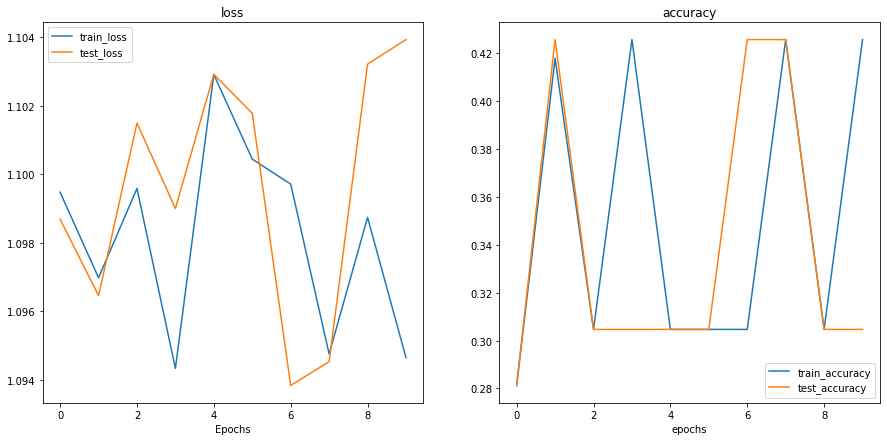

In [71]:
plot_loss_curves(model_0_results)